# Touch Detection Prototyping

## Goals and Requirements

### Input

The raw touch input is provided as capacitive heatmap.
The resolution of this heatmap is significantly lower than the resolution of the actual screen, which in turn may be lower than the final resolution in which the processed touch point descriptions should be provided.
The input is likely noisy, thus additional precautions may be necessary.

### Output

This project is mainly intended to provide a robust algorithm for use in a Linux kernel module.
In the Linux kernel, touch points can be described via an ellipse representing the contact point (see https://www.kernel.org/doc/html/latest/input/multi-touch-protocol.html for details).
Note: We will for now neglect the appropriate scaling of coordinates to output dimensions.
Thus the provided output for some touch point $i$ is $t_i = (c_i, \theta_i, h_i, w_i)$ with

- $c_i \in \mathbb{R}^{2}$ as the center of the contact point,
- $h_i \in \mathbb{R}$ as the height of the ellipse, i.e. its size along its major axis,
- $w_i \in \mathbb{R}$ as the width of the ellipse, i.e. its size along its minor axis (note that the axes are orthogonal), and
- $\theta_i \in [0,2\pi]$ as the angle of the major axis of the ellipse.

In addition, proper handling of touch points requires tracking of the contact points across consecutive input data frames.
This can be seen as a separate problem ontop of the contact point identification and will be discussed later.
Similarly, handling of noise can be discussed as a separate problem applied to the output data.

## First Approach: A Simplified Setting

Let us for now assume that we only have a single point of contact.
Considering that we need to model the contact point as an ellipse, a two-dimensional Gaussian $\mathcal{N}(x \mid \mu, \Sigma)$ seems like a good choice to start: The mean $\mu \in \mathbb{R}^2$ of the Gaussian directly provides us with the center of the contact point while a confidence bound derived from the covariance matrix $\Sigma \in \mathbb{R}^{2 \times 2}$ provides us with the shape of the ellipse.
This also allows for a neat probabilistic interpretation: $\mathcal{N}(x \mid \mu, \Sigma)$ represents the probability of $x \in \mathbb{R}^2$ being the center of the contact area.

Estimation of the Gaussian is fairly straightforward.
Note that we, however, do not deal with uniformly weighted random samples but instead with a grid, where points have associated values derived from the capacity data of the touchscreen, determining their sample weights.
This suggests modifying the classical maximum likelihood estimators (MLE), yielding

\begin{align*}
    \mathbb{E}[\mu] &= \sum_{(x_i, y_i) \in \mathcal{S}} y_i \cdot x_i \\
    \mathbb{E}[\Sigma] &= \sum_{(x_i, y_i) \in \mathcal{S}} y_i \cdot \left(x - \mu\right)
        \left(x - \mu\right)^\intercal
\end{align*}

where $S$ is the set of samples $x_i \in \mathbb{R}^2$ associated with normalized sample weights $y_i \in \mathbb{R}$, such that $\sum_i y_i = 1$ holds.

Let us now apply this.
First we generate some input data for a single contact point, using a Gaussian.
Here we already assume that the input data is pre-processed sufficiently and has normalized values.
We will neglect handling of noise and assume that there are no contact areas intersecting with the boundary.

In [1]:
# imports
import numpy as np
import scipy as sp
import itertools
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
%matplotlib notebook

plt.rcParams['figure.max_open_warning'] = 30

In [2]:
# general parameters
input_width, input_height = 0x48, 0x30

In [3]:
def cov(angle, width, height):
    """Generate a 2D covariance matrix from the given confidence bound shape"""
    e1 = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]) @ np.array([1.0, 0.0])
    e2 = np.array([[0.0, -1.0], [1.0, 0.0]]) @ e1
    return height * np.outer(e1, e1) + width * np.outer(e2, e2)

def generate_input(width, height, params):
    """Generate artificial input data"""
    data = np.zeros(shape=(width, height))

    for mu, sigma in params:
        for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
            data[x1, x2] += multivariate_normal.pdf(np.array([x1, x2]), mu, sigma)

    return data

# parameters for data
mu_real = np.array([15.3, 10.6])
sigma_real = cov(np.deg2rad(35), 1.0, 2.0)

# simulate input data
data = generate_input(input_width, input_height, [(mu_real, sigma_real)])

<IPython.core.display.Javascript object>


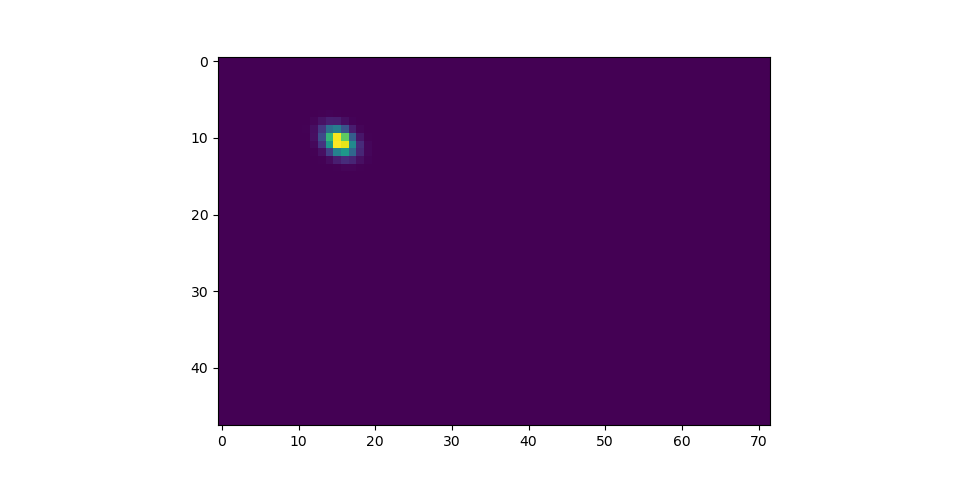

In [4]:
fig, ax = plt.subplots()
ax.imshow(data.T)
plt.show()

Now let's try to reconstruct the parameters for the original Gaussian using the MLEs.
First estimate the mean $\mu$:

In [5]:
def mle_mean(data):
    mu = np.zeros(shape=2)

    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        mu += np.array([x1, x2]) * data[x1, x2]

    return mu

mu = mle_mean(data)

and from that estimate the covariance matrix $\Sigma$:

In [6]:
def mle_cov(data, mu):
    sigma = np.zeros(shape=(2, 2))

    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        d = np.array([x1, x2]) - mu
        sigma += np.outer(d, d) * data[x1, x2]
    
    return sigma

sigma = mle_cov(data, mu)

To see how good this estimate is we can first look at the errors

In [7]:
print(f"error in mu:    {np.linalg.norm(mu_real - mu)}")
print(f"error in sigma: {np.linalg.norm(sigma_real - sigma, ord=np.inf)}")

error in mu:    9.124653467372391e-11
error in sigma: 6.062403357098844e-10


and then also plot the results:

In [8]:
from matplotlib.patches import Ellipse

def plot_cov_ellipse(ax, mu, sigma, nstd, **kwargs):
    """Plot ellipse representing confidence bound with nstd times the standard deviation"""
    eigvals, eigvecs = np.linalg.eigh(sigma)

    vx, vy = eigvecs[:, 0][0], eigvecs[:, 0][1]
    angle = np.arctan2(vy, vx)

    width, height = 2.0 * nstd * np.sqrt(eigvals)
    ax.add_artist(Ellipse(xy=mu, width=width, height=height, angle=np.degrees(angle), **kwargs))

def plot_mean(ax, mu, **kwargs):
    """Plot mean as cross"""
    ax.plot([mu[0], mu[0]], [mu[1] - 0.4, mu[1] + 0.4], **kwargs)
    ax.plot([mu[0] - 0.4, mu[0] + 0.4], [mu[1], mu[1]], **kwargs)

def plot_gaussian(ax, mu, sigma, nstd, color):
    """Plot Gaussian with confidence bound"""
    plot_mean(ax, mu, color=color)
    plot_cov_ellipse(ax, mu, sigma, 2.0, facecolor='none', edgecolor=color)
    

<IPython.core.display.Javascript object>


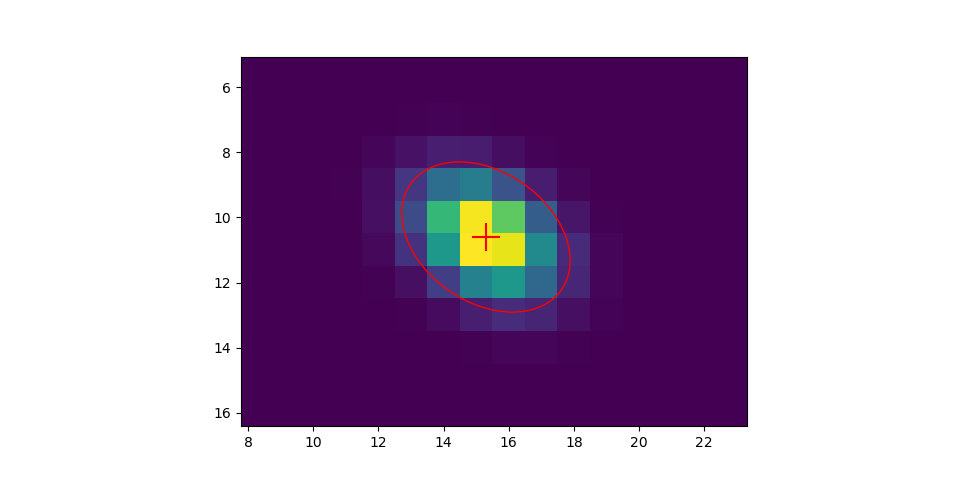

In [9]:
fig, ax = plt.subplots()
ax.imshow(data.T)
plot_gaussian(ax, mu, sigma, 2.0, color='red')

As we can see, this provides a fairly good reconstruction.
Applied to real data, the estimator of the mean provides sufficiently good resolution and accuracy.
Tuning the `nstd` parameter allows to accurately reconstruct the physical contact area.
Performance, however, is suboptimal as we look at the full heatmap.
This can be improved by first identifying the maximum and then restricting mean and covariance computation to a local area around it.
Furthermore, these estimators break down completely when dealing with multiple touch points:

In [10]:
# generate two contact points
mu1 = np.array([10.0, 20.0])
mu2 = np.array([20.0, 20.0])
sigma = np.identity(2)
data = generate_input(input_width, input_height, [(mu1, sigma), (mu2, sigma)])

# estimate mean and covariance
mu = mle_mean(data / np.sum(data))
sigma = mle_cov(data / np.sum(data), mu)

<IPython.core.display.Javascript object>


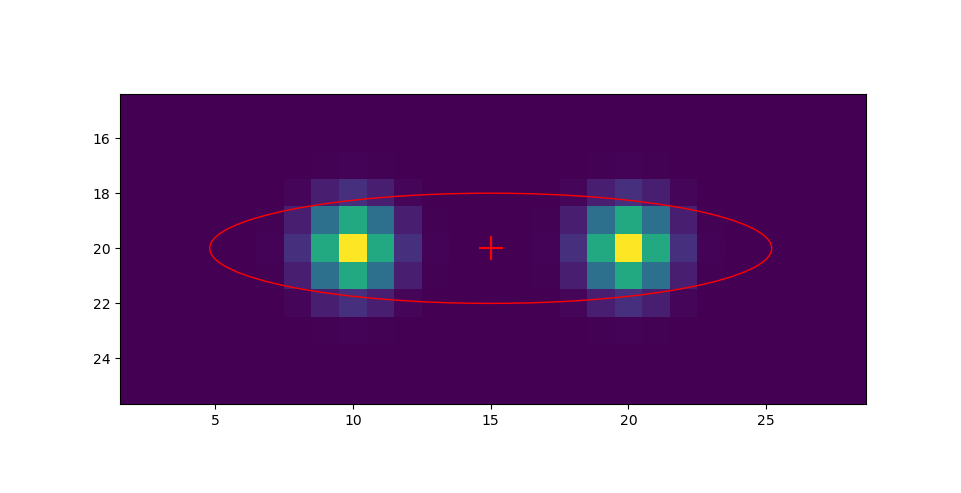

In [11]:
fig, ax = plt.subplots()
ax.imshow(data.T)
plot_gaussian(ax, mu, sigma, 2.0, color='red')

This is expected, as our current estimators are only designed for reconstructing a single Gaussian.
Also note that we normalize the data here so that we can actually use it as weights.
Next, we will look at how we can extend this approach to multiple Gaussians.

## Extending the Approach to Multiple Contact Points

The basic idea of this is given in Gaussian Mixture Models (GMMs).
While GMMs generally work with random samples and we instead work on a grid with associated weights, the core idea is transferable.

Let us first begin by again creating some artificial input data, this time with two contact areas:

In [12]:
# parameters for data
mu1_real = np.array([15.3, 10.6])
sigma1_real = cov(np.deg2rad(35), 1.0, 2.0)

mu2_real = np.array([35.8, 15.1])
sigma2_real = cov(np.deg2rad(-15), 1.0, 2.0) * 0.3

params_real = [(mu1_real, sigma1_real), (mu2_real, sigma2_real)]

# simulate input data
data = generate_input(input_width, input_height, params_real)

<IPython.core.display.Javascript object>


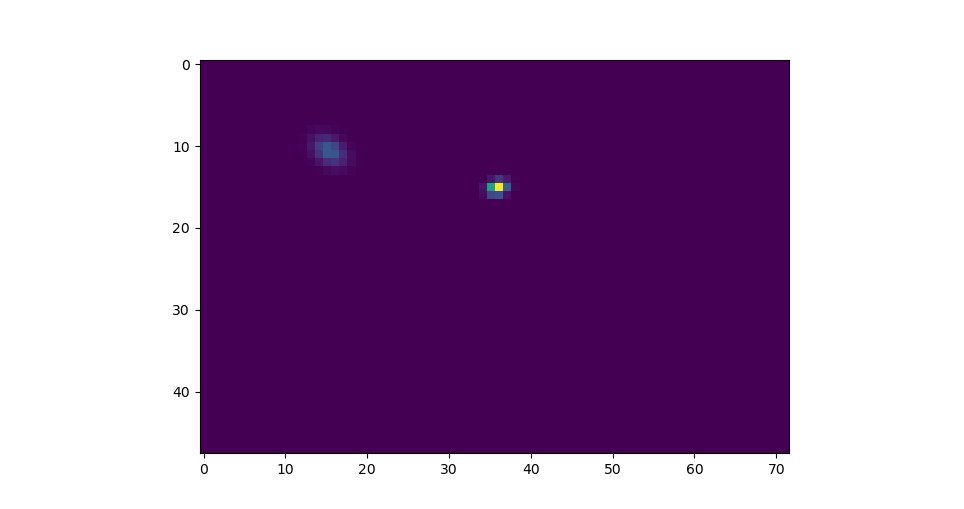

In [13]:
fig, ax = plt.subplots()
_ = ax.imshow(data.T)

The fundamental idea behind GMMs is an iterative approach:
We start with an initial estimation and then iteratively improve upon this until the changes between iterations are sufficiently small or we've reached the desired accuracy.
So before looking at the acutal algorithm, let's discuss how we get to the initial estimate, first looking at the mean.

In general, we expect contact areas to be centered around a local maximum, which directly leads us to the initial estimate:
Just look for local maximas and assume it is the center of the corresponding contact area.
This also directly gives us the number of contact areas.
Note that we still want to improve upon this first estimate as it is limited to the sensor resolution.

Looking for local maximas is straightforward, we just compare the value each node to the ones of its neighbors.
To make it a bit more robust (and handle borders, where we set the value of the neighbor to zero) we also add a threshold, meaning that the local maxima has to be at least a certain amount over the average (alternatively we could use the minimum).
Note that this will detect two maximas in case of two neighboring cells with equal values that are otherwise local maximas.
We assume for now that this case will never happen.

In [14]:
def get_local_maximas(data, delta=0.01):
    threshold = np.average(data) + delta

    result = []
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        ax1, bx1 = max(x1 - 1, 0), min(x1 + 1, data.shape[0] - 1)
        ax2, bx2 = max(x2 - 1, 0), min(x2 + 1, data.shape[1] - 1)
        
        if data[x1, x2] < threshold:
            continue
        
        area = itertools.product(range(ax1, bx1+1), range(ax2, bx2+1))
        if np.all([(data[x1, x2] >= data[ix1, ix2]) for ix1, ix2 in area]):
            result += [np.array([x1, x2])]
            
    
    return result

maximas = get_local_maximas(data)
maximas

[array([15, 11]), array([36, 15])]

Highlighting the local maximas shows that, while we are limited to the resolution of the sensor, the estimates are fairly good.

<IPython.core.display.Javascript object>


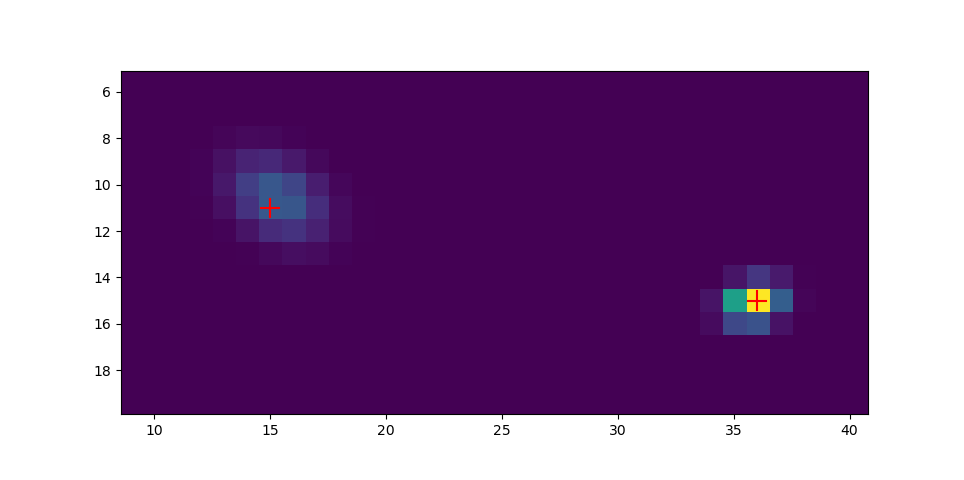

In [15]:
fig, ax = plt.subplots()
ax.imshow(data.T)

for m in maximas:
    plot_mean(ax, m, color='red')

Now we have the estimates for the means of the Gaussian and we know how many we should try to fit to the data, but we also require estimates for the covariance matrices.
Unfortunately, for those we don't have a good way of estimating them, so we just assume that they are the identity matrix.
In general we would want to scale them a bit to represent the "average" contact area.
Note that the scaled identity as covariance matrix still creates a circular confidence bound, so we don't encode any directional information in our initial guess (i.e. more information than we actually have), which is a good idea.

With that, we have the following initial estimates:

In [16]:
# initial estimate
mu_init = maximas
sigma_init = [np.identity(2), np.identity(2)]

params_init = list(zip(mu_init, sigma_init))

Plotting them shows that they fit fairly well for an initial guess, but of course still require improvement.

<IPython.core.display.Javascript object>


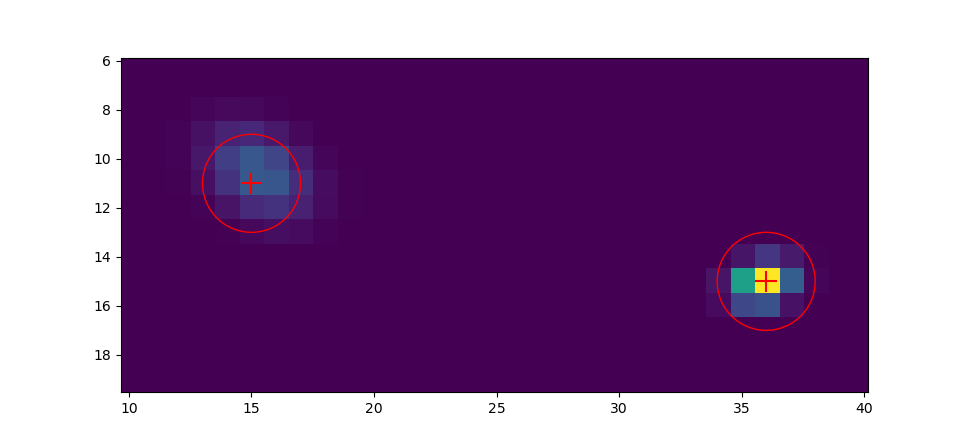

In [17]:
fig, ax = plt.subplots()
ax.imshow(data.T)
for mu, sigma in params_init:
    plot_gaussian(ax, mu, sigma, 2.0, color='red')

With that, we have all the prequisites we need for the actual improvement iterations.

To fully understand the following algorithm let us first look at the classical usage of GMMs for clustering.
In this setting, we have samples $x \in \mathbb{R}^d$ with an associated label $y \in \{1, 2, \ldots, n_{\text{clusters}}\}$ that we want to find.
Note that this is different to our touch detection scenario in that the samples for the clustering scenario do not have to be on a grid, and second, in our scenario we have weights associated with each sample.

A single iteration in GMMs for clustering then consists of two fundamental steps:
1. Use the current estimates to associate each sample with a cluster:
   For each sample $x$ and cluster $c$ compute the probability of the sample belonging to the cluster by evaluating $\mathcal{N}(x \mid \mu_c, \Sigma_c)$, then choose the cluster with the highest probability.
   Here $\mu_c$ and $\Sigma_c$ are the current estimates.
2. Update the estimates based on this association:
   For each cluster, update the estimated mean and covariance matrix using the usual MLE estimators.
   For these estimators, only use the samples that have been associated with the respective cluster in step 1.

This already highlights a fundamental difference between the two scenarios:
In the clustering scenario, we assume that a sample belongs to a single cluster only.
In the contact area detection, however, the sensor values are generally additive blends:
Consider the values of two overlapping contact areas.
At the intersection of those areas, the values of both individual contact Gaussians are added together (or at least we assume them to be).
This in turn means that a sample inside this intersaction is (generally non-equally) shared and we will have to weight it accordingly.
Attributing the full value of such a sample to a single Gaussian will thus skew the estimates.

Let us ignore the issue of overlapping contact areas for now and look at two non-overlapping areas.
For this, we obtain the algorithm below.
Note that we have to take care to normalize our estimates as those are basically weighted averages.

In [18]:
def gmm_iteration(data, params):
    """A single GMM iteration"""
    mu = np.zeros(shape=(len(params), 2))
    sigma = np.zeros(shape=(len(params), 2, 2))
    norm = np.zeros(shape=len(params))

    # compute norms
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        x = np.array([x1, x2])
        y = [multivariate_normal.pdf(x, mu, sigma) for mu, sigma in params]
        i = np.argmax(y)

        norm[i] += data[x1, x2]

    # estimate means
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        x = np.array([x1, x2])
        y = [multivariate_normal.pdf(x, mu, sigma) for mu, sigma in params]
        i = np.argmax(y)

        mu[i] += x * data[x1, x2] / norm[i]

    # estimate covariance matrices
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        x = np.array([x1, x2])
        y = [multivariate_normal.pdf(x, mu, sigma) for mu, sigma in params]
        i = np.argmax(y)

        sigma[i] += np.outer(x - mu[i], x - mu[i]) * data[x1, x2] / norm[i]

    return list(zip(mu, sigma))

def gmm(data, params, n, params_real):
    """Perform n GMM iterations and after each print the current error"""
    for i in range(0, n):
        params = gmm_iteration(data, params)
        
        # compute and display error
        mu, sigma = zip(*params)
        mu_real, sigma_real = zip(*params_real)
        mu, mu_real, sigma, sigma_real = np.array(mu), np.array(mu_real), np.array(sigma), np.array(sigma_real)

        print(f"iteration: {i}")
        print(f"  errors in mu:    {np.linalg.norm(mu_real - mu, axis=1)}")
        print(f"  errors in sigma: {np.linalg.norm(sigma_real - sigma, axis=(1,2), ord=np.inf)}")
    
    return params

With that we can then apply the algorithm to our example and plot the results:

iteration: 0
  errors in mu:    [4.20253858e-11 4.39134374e-03]
  errors in sigma: [6.17710660e-10 1.45549484e-02]
iteration: 1
  errors in mu:    [4.20585276e-11 4.39134374e-03]
  errors in sigma: [6.18021412e-10 1.45549484e-02]
iteration: 2
  errors in mu:    [4.20585276e-11 4.39134374e-03]
  errors in sigma: [6.18021412e-10 1.45549484e-02]


<IPython.core.display.Javascript object>


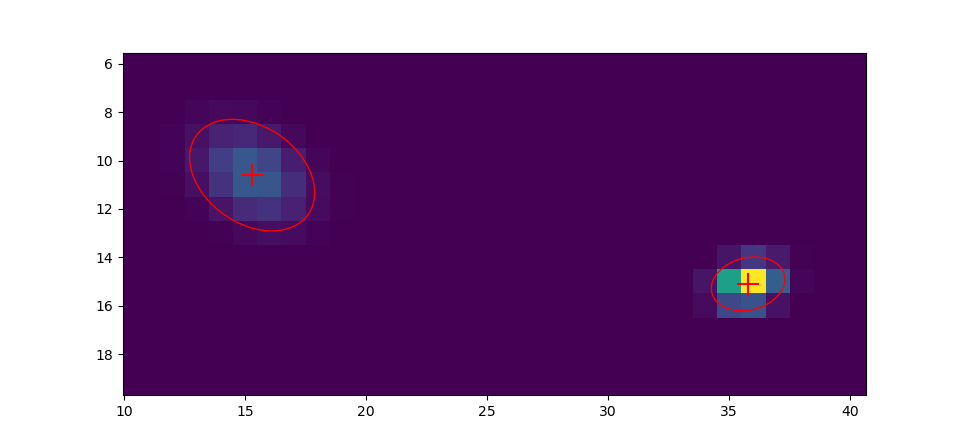

In [19]:
params_est = gmm(data, params_init, 3, params_real)

fig, ax = plt.subplots()
ax.imshow(data.T)

for mu, sigma in params_est:
    plot_gaussian(ax, mu, sigma, 2.0, color='red')

As we can see from the error values, even after only a single iteration the results are fairly good.
Further iterations do not improve the estimate, likely due to the close initial estimation.

Now let's look at how this performs for overlapping Gaussians:

iteration: 0
  errors in mu:    [0.14571857 0.14571857]
  errors in sigma: [0.59473598 0.59473598]
iteration: 1
  errors in mu:    [0.14571851 0.14571851]
  errors in sigma: [0.59473535 0.59473535]
iteration: 2
  errors in mu:    [0.14571851 0.14571851]
  errors in sigma: [0.59473535 0.59473535]


<IPython.core.display.Javascript object>


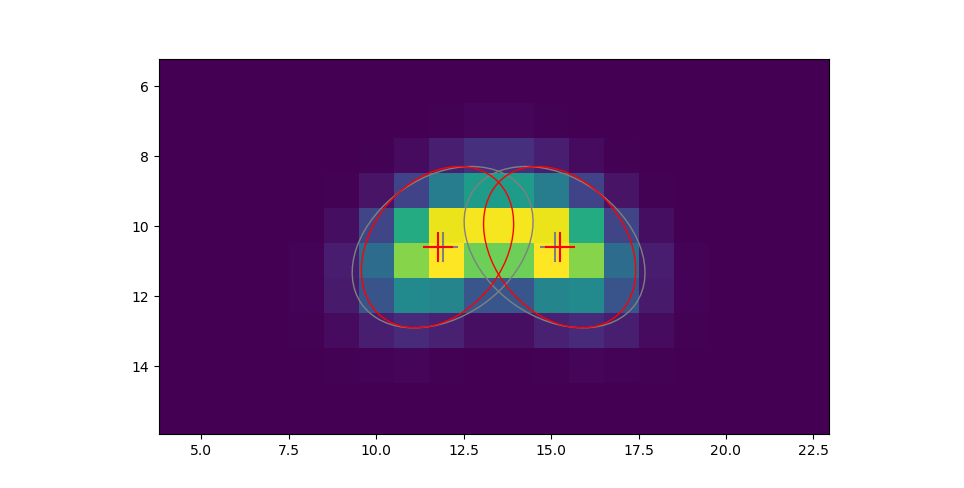

In [20]:
# parameters for data
mu1_real = np.array([11.9, 10.6])
sigma1_real = cov(np.deg2rad(-35), 1.0, 2.0)

mu2_real = np.array([15.1, 10.6])
sigma2_real = cov(np.deg2rad(35), 1.0, 2.0)

params_real = [(mu1_real, sigma1_real), (mu2_real, sigma2_real)]

# simulate input data
data = generate_input(input_width, input_height, params_real)

# initial estimate
mu_init = get_local_maximas(data)
sigma_init = [np.identity(2), np.identity(2)]

params_init = list(zip(mu_init, sigma_init))

# compute estimate
params_est = gmm(data, params_init, 3, params_real)

# plot
fig, ax = plt.subplots()
ax.imshow(data.T)

for mu, sigma in params_real:
    plot_gaussian(ax, mu, sigma, 2.0, color='grey')

for mu, sigma in params_est:
    plot_gaussian(ax, mu, sigma, 2.0, color='red')

While, visually and on their own, the results look fairly good, when comparing them to the real solution, however, we can see that there is room for improvement.
We again note that subsequent iterations do not significantly improve upon the initial result.
Let's see if we can increase the accuracy.

As hinted above, the basic idea for this is the consideration that instead of fully belonging to a single contact areas, samples can actually belong to multiple areas with different weights associated per area.
So instead of the `argmax` in the algorithm above, we now compute said weights based on the previously estimated Gaussians.
To do this, we simply evaluate all Gaussians for the sample and then instead of looking for the maximum value, we compute a weight for each Gaussian by normalizing its value at the sample point with the sum of all Gaussians at the sample point.
Then we use these weights to distribute the sample accross all Gaussians, yielding

In [21]:
def gmm_iteration(data, params):
    """A single GMM iteration"""
    mu = np.zeros(shape=(len(params), 2))
    sigma = np.zeros(shape=(len(params), 2, 2))
    norm = np.zeros(shape=len(params))

    # compute norms
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        x = np.array([x1, x2])
        y = np.array([multivariate_normal.pdf(x, mu, sigma) for mu, sigma in params])
        w = y / np.sum(y) if np.sum(y) > 1e-20 else np.zeros(shape=len(params))

        norm += data[x1, x2] * w

    # estimate means
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        x = np.array([x1, x2])
        y = [multivariate_normal.pdf(x, mu, sigma) for mu, sigma in params]
        y = np.array([multivariate_normal.pdf(x, mu, sigma) for mu, sigma in params])
        w = y / np.sum(y) if np.sum(y) > 1e-20 else np.zeros(shape=len(params))

        for i in range(len(params)):
            mu[i] += x * data[x1, x2] * w[i] / norm[i]

    # estimate covariance matrices
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        x = np.array([x1, x2])
        y = np.array([multivariate_normal.pdf(x, mu, sigma) for mu, sigma in params])
        w = y / np.sum(y) if np.sum(y) > 1e-20 else np.zeros(shape=len(params))
        
        for i in range(len(params)):
            sigma[i] += np.outer(x - mu[i], x - mu[i]) * data[x1, x2] * w[i] / norm[i]

    return list(zip(mu, sigma))

Now again evaluate the results as above:

iteration: 0
  errors in mu:    [0.08006306 0.08006306]
  errors in sigma: [0.34819532 0.34819532]
iteration: 1
  errors in mu:    [0.04681595 0.04681595]
  errors in sigma: [0.19161423 0.19161423]
iteration: 2
  errors in mu:    [0.02863828 0.02863828]
  errors in sigma: [0.1155695 0.1155695]
iteration: 3
  errors in mu:    [0.01791038 0.01791038]
  errors in sigma: [0.07196658 0.07196658]
iteration: 4
  errors in mu:    [0.01134216 0.01134216]
  errors in sigma: [0.04549772 0.04549772]
iteration: 5
  errors in mu:    [0.00723679 0.00723679]
  errors in sigma: [0.02900581 0.02900581]
iteration: 6
  errors in mu:    [0.00463886 0.00463886]
  errors in sigma: [0.01858451 0.01858451]
iteration: 7
  errors in mu:    [0.00298223 0.00298223]
  errors in sigma: [0.01194432 0.01194432]
iteration: 8
  errors in mu:    [0.00192077 0.00192077]
  errors in sigma: [0.00769167 0.00769167]
iteration: 9
  errors in mu:    [0.00123858 0.00123858]
  errors in sigma: [0.00495931 0.00495931]


<IPython.core.display.Javascript object>


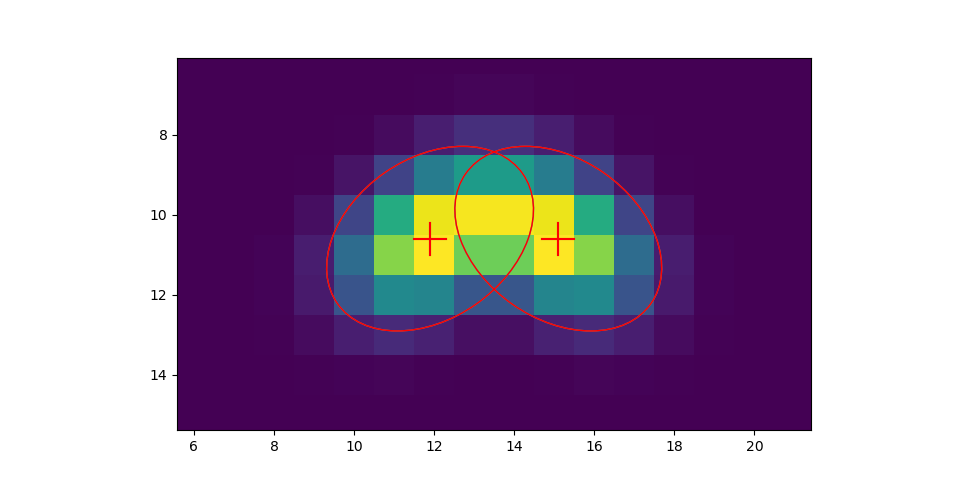

In [22]:
# compute estimate
params_est = gmm(data, params_init, 10, params_real)

# plot
fig, ax = plt.subplots()
ax.imshow(data.T)

for mu, sigma in params_real:
    plot_gaussian(ax, mu, sigma, 2.0, color='grey')

for mu, sigma in params_est:
    plot_gaussian(ax, mu, sigma, 2.0, color='red')

This time, we can see that we have reconstructed the Gaussians almost perfectly, given we perform enough iterations.
Note that in this case, subsequent iterations do significantly improve upon the first one, owing to the newly calcualted weights.

Before we continue let's have a look at the things left to do:
Firstly, we still haven't looked at the boundaries.
Due to the mean computation as weighted average, touch points close to it will have a drift towards the center of the screen if that is not handled properly.
Second, our current method of detecting local maximas is flawed as it detects neighboring cells with exactly the same value, higher than their neighbours except for each other, as two independent local maximas.
This will, however, inevevitably lead to two contact points converging to the same Gaussian descriptor, something we should try to avoid at all cost.
Third, we need to get the performance to an acceptable level as it is currently nowhere near real-time.

Let's start with the low-hanging fruit first:
Improving the local maxima detection algorithm.

## Improving Local Maxima Detection

Let's first create some problematic input data

In [23]:
data = np.zeros(shape=(input_width, input_height))
data[20:22,20:22] = 1.0

which we are then going to plot:

<IPython.core.display.Javascript object>


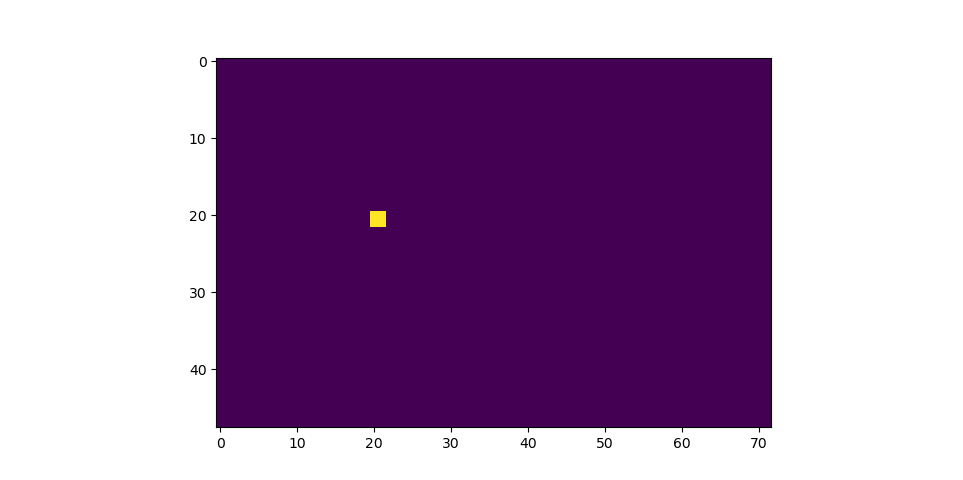

In [24]:
fig, ax = plt.subplots()
ax.imshow(data.T)
plt.show()

These are simply four cells with the same value of one, while all other cells have the value of zero.
Ideally, we would recognize a single local maximum, located in the center of the four cells.
Note that the location of the maximum is not that important, since the iterative scheme of the algorithm will correct it.
Not caring about the actual location will make our task easier, however, detecting four local maximas, one per cell, as our current algorithm does, is (still) not acceptable.

Let's look at this now:

<IPython.core.display.Javascript object>


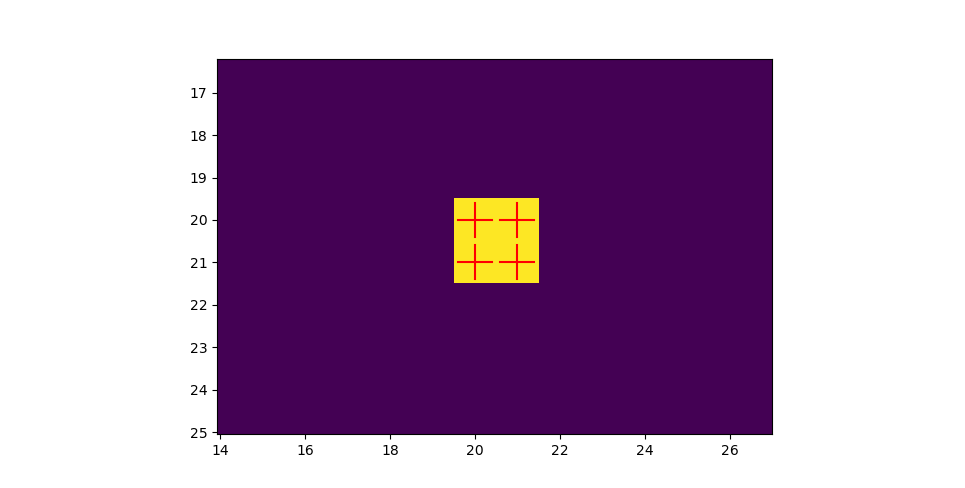

In [25]:
maximas = get_local_maximas(data)

fig, ax = plt.subplots()
ax.imshow(data.T)

for m in maximas:
    plot_mean(ax, m, color='red')

In essence this can be fixed by providing a tie-breaker:
When the value of the cells are equal, ensure a total order by comparing a second, unique feature.
In our case, this feature is the coordinate of the cell.
Note that in python, this can be easily done by comparing tuples `(value, coordinate_x, coordinate_y)` instead of just `value`.

In [26]:
def get_local_maximas(data, delta=0.01):
    threshold = np.average(data) + delta

    result = []
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        if data[x1, x2] < threshold:
            continue

        ax1, bx1 = max(x1 - 1, 0), min(x1 + 1, data.shape[0] - 1)
        ax2, bx2 = max(x2 - 1, 0), min(x2 + 1, data.shape[1] - 1)
        
        area = itertools.product(range(ax1, bx1+1), range(ax2, bx2+1))
        if np.all([((data[x1, x2], x1, x2) >= (data[ix1, ix2], ix1, ix2)) for ix1, ix2 in area]):
            result += [np.array([x1, x2])]
    
    return result

With that implemented, let's look at the new results:

<IPython.core.display.Javascript object>


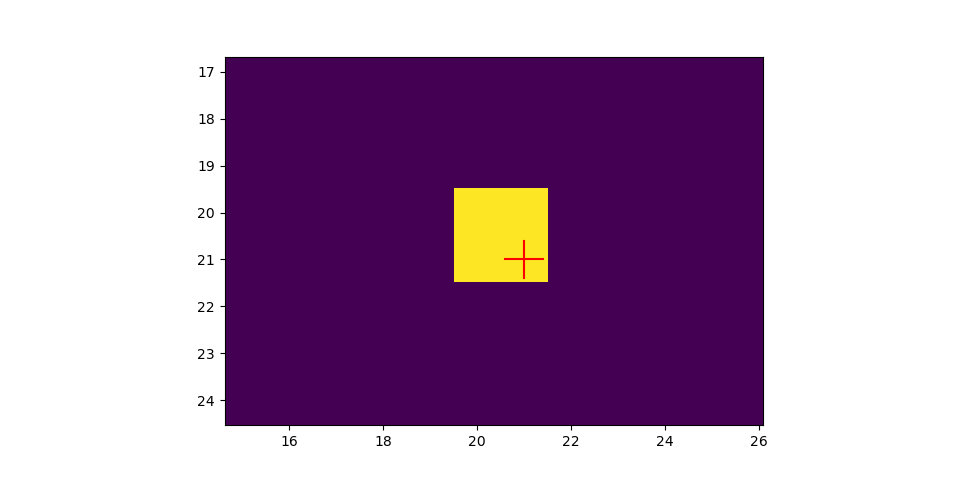

In [27]:
maximas = get_local_maximas(data)

fig, ax = plt.subplots()
ax.imshow(data.T)

for m in maximas:
    plot_mean(ax, m, color='red')

As we can see, now only the lower-right cell is detected as a local maximum, due to using the respective coordinates to introduce a total order, thanks to which the cluster of neighboring cells with the same value is correctly identified as a single maximum.

## Dealing with Boundaries

Before we try to handle boundaries, let's confirm that this is indeed an issue that we should take care of.
First, generate some input data.

In [28]:
# parameters for data
mu_real = np.array([-0.33, 10.6])
sigma_real = cov(np.deg2rad(-35), 1.0, 2.0)

params_real = [(mu_real, sigma_real)]

# simulate input data
data = generate_input(input_width, input_height, params_real)

Then, let's look at the results of our current algorithm.

iteration: 0
  errors in mu:    [0.98400739]
  errors in sigma: [1.36716855]
iteration: 1
  errors in mu:    [0.98400739]
  errors in sigma: [1.36716859]
iteration: 2
  errors in mu:    [0.98400739]
  errors in sigma: [1.36716859]


<IPython.core.display.Javascript object>


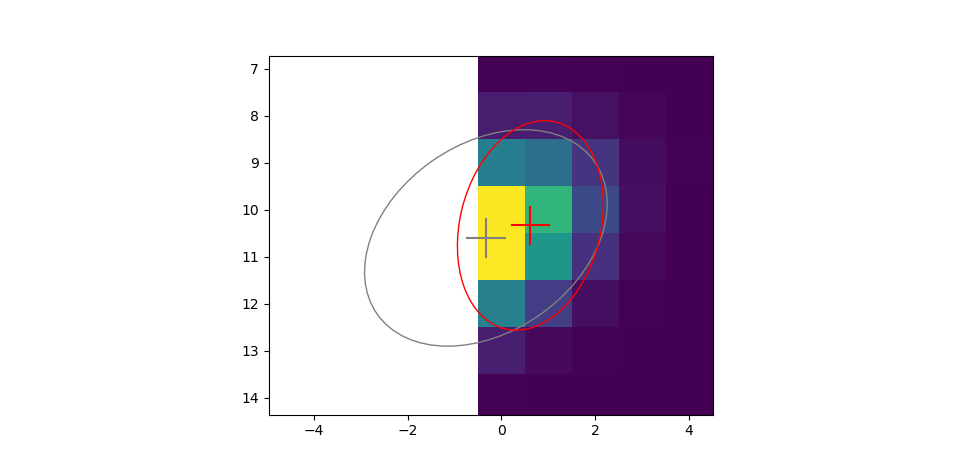

In [29]:
# initial estimate
mu_init = get_local_maximas(data)
sigma_init = [np.identity(2)]

params_init = list(zip(mu_init, sigma_init))

# compute estimate
params_est = gmm(data, params_init, 3, params_real)

# plot
fig, ax = plt.subplots()
ax.imshow(data.T)

for mu, sigma in params_real:
    plot_gaussian(ax, mu, sigma, 2.0, color='grey')

for mu, sigma in params_est:
    plot_gaussian(ax, mu, sigma, 2.0, color='red')

As was to be expected, the use of a weighted average for the mean "pulls" it inside.
This is not surprising, considering that amlost half a side of the Gaussian, the part outside of the screen area, is missing.
So there is nothing to "pull" it towards the border.
This effectively indicates that with our current method, we cannot handle points on the edges of the screen accurately, which, however, is important especially due to gesture input (wipe from screen edge to pull up menus) or window management (the top bar may be at the top of the screen, buttons for closing windows are at the edges).

However, the mean is not the only problem:
Let's assume for a moment that we have a magic algorithm (aka. an oracle) which gives us the original mean.
How does the MLE of the covariance matrix look like?

<IPython.core.display.Javascript object>


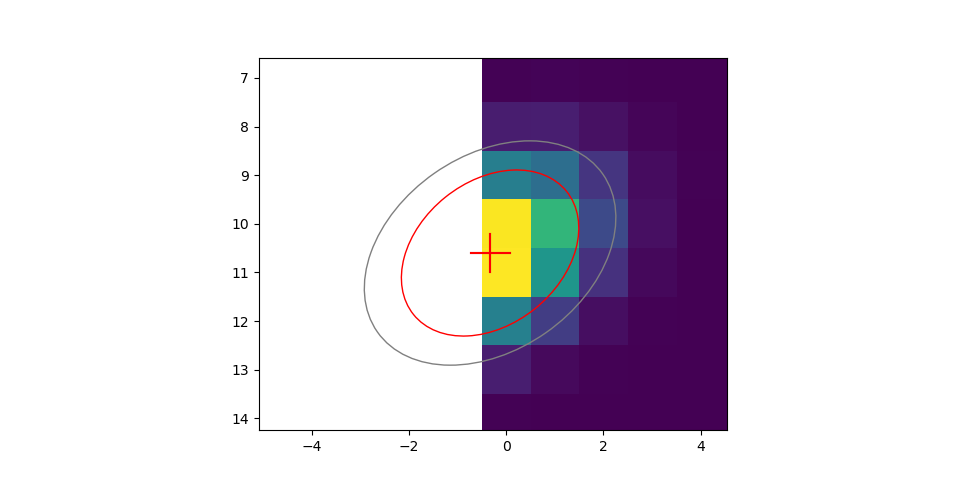

In [30]:
# compute estimate
sigma_est = mle_cov(data, mu_real)
params_est = [(mu_real, sigma_est)]

# plot
fig, ax = plt.subplots()
ax.imshow(data.T)

for mu, sigma in params_real:
    plot_gaussian(ax, mu, sigma, 2.0, color='grey')

for mu, sigma in params_est:
    plot_gaussian(ax, mu, sigma, 2.0, color='red')

We see that even if we had such an oracle, the covariance matrix would also be wrongly scaled.
This is also not that surprising:
While half (or at the corners maybe even a quarter) of a Gaussian may still be enough to estimate the shape, since the MLE is a weighted sum, approximately half of the weights missing means that we get a result with approximately half the scale.
In our case, scaling the covariance matrix by a factor of 2, however, the actual factor depends on how much of the Gaussian is missing.
Since we use the covariance matrix to estimate the shape of the contact area, this is also something we need to take care of.

To fix the scaling problem, we can think of two major options:
first, try to estimate the scale by estimating the fraction of the part outside of the area, or second, try to estimate the scale by solving an optimization problem, e.g. squared error between estimated Gaussian and actual values (note that we would also have to take care of overlapping contact areas here).

Speaking of solving optimization problems:

## Directly Fitting a Gaussian via an Optimization Problem

Up to now we've avoided the discussion of estimating the contact descriptors by explicitly solving an optimization problem.
The main reason for this is concern about performance:
The final algorithm should be capable of running multiple times per second, which might be problematic with straight-forward downhill optimization methods running on the full sensor resolution.
On the other hand, by directly posing and solving an optimization problem we can expect a sufficiently accurate solution (given appropriate initial parameters and solver iterations), including at boundaries.

Note that our current GMM approach using MLE estimators is already inherently the result of optimization, however, for a slightly different problem, thus creating the issues described above.

Let's begin by stating our objective function.
Instead of fitting a Gaussian, we will fit a scaled Gaussian as, in general, we can't rely on the input data being scaled correctly.
Fortunately, this actually makes things easier for us (e.g. when computing the derivaties) and allows us to integrate the determinant factor of the usual Gaussian scaling factor into the estimated scaling factor.
By simply penalizing the error with mean squares, we obtain the objective function

$$
\begin{align*}
    \theta^*
    &= \operatorname*{arg\,min}_{c, \mu, \Sigma^{-1}}
        \sum_{(x_i, y_i) \in \mathcal{S}}
        \left(
            c \cdot \exp\left\{-\frac{1}{2} (x_i - \mu)^\intercal \Sigma^{-1} (x_i - \mu) \right\}
            - y_i
        \right)^2 \\
    &= \mathcal{L}(c, \mu, \Sigma^{-1})
\end{align*}
$$

where $\theta = (c, \mu, \Sigma^{-1})$ are our parameters and $\mathcal{S}$ is the set of samples with point $x_i \in \mathbb{R}^2$ and value $y_i \in \mathbb{R}$.
Further, $c \in \mathbb{R}$ is the scale and $\mu \in \mathbb{R}^2$, $\Sigma \in \mathbb{R}^{2 \times 2}$ are, as above, mean and covariance of the Gaussian.
Note that we directly optimize for $\Sigma^{-1}$.

To properly optimize, we also need the partial derivatives.
For those, let us first define $d = (x - \mu)$.
With that, they can then be given as

$$
\begin{align*}
    \frac{\partial}{\partial c} \mathcal{L}(c, \mu, \Sigma^{-1})
        &= 2 \cdot \sum_{(x_i, y_i) \in \mathcal{S}}
            \left(
                c \cdot \exp\left\{-\frac{1}{2} d^\intercal \Sigma^{-1} d \right\}
                - y_i
            \right)
            \cdot \exp\left\{-\frac{1}{2} d^\intercal \Sigma^{-1} d \right\} \\
    \frac{\partial}{\partial \mu} \mathcal{L}(c, \mu, \Sigma^{-1})
        &= 2c \cdot \sum_{(x_i, y_i) \in \mathcal{S}}
            \left(
                c \cdot \exp\left\{-\frac{1}{2} d^\intercal \Sigma^{-1} d \right\}
                - y_i
            \right)
            \cdot \exp\left\{-\frac{1}{2} d^\intercal \Sigma^{-1} d \right\}
            \cdot d^\intercal \Sigma^{-1} \\
    \frac{\partial}{\partial \Sigma^{-1}} \mathcal{L}(c, \mu, \Sigma^{-1})
        &= -c \cdot \sum_{(x_i, y_i) \in \mathcal{S}}
            \left(
                c \cdot \exp\left\{-\frac{1}{2} d^\intercal \Sigma^{-1} d \right\}
                - y_i
            \right)
            \cdot \exp\left\{-\frac{1}{2} d^\intercal \Sigma^{-1} d \right\}
            \cdot dd^\intercal
\end{align*}
$$

Now let's implement those functions:

In [31]:
def loss(c, mu, sigma_inv, data):
    mu = np.matrix(mu).T
    sigma_inv = np.matrix(sigma_inv)

    result = 0.0
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        x = np.matrix([x1, x2]).T
        d = x - mu

        a = -0.5 * (d.T * sigma_inv * d).item()
        result += (c * np.exp(a) - data[x1, x2])**2
    
    return result

def d_loss_d_c(c, mu, sigma_inv, data):
    mu = np.matrix(mu).T
    sigma_inv = np.matrix(sigma_inv)

    result = 0.0
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        x = np.matrix([x1, x2]).T
        d = x - mu

        a = -0.5 * (d.T * sigma_inv * d).item()
        result += (c * np.exp(a) - data[x1, x2]) * np.exp(a)
    
    return 2.0 * result

def d_loss_d_mu(c, mu, sigma_inv, data):
    mu = np.matrix(mu).T
    sigma_inv = np.matrix(sigma_inv)

    result = np.matrix(np.zeros(shape=(2,)))
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        x = np.matrix([x1, x2]).T
        d = x - mu
        
        a = -0.5 * (d.T * sigma_inv * d).item()
        result += (c * np.exp(a) - data[x1, x2]) * np.exp(a) * (d.T * sigma_inv)
    
    return 2.0 * c * result

def d_loss_d_sigma(c, mu, sigma_inv, data):
    mu = np.matrix(mu).T
    sigma_inv = np.matrix(sigma_inv)

    result = np.zeros(shape=(2,2))
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        x = np.matrix([x1, x2]).T
        d = x - mu
        
        a = -0.5 * (d.T * sigma_inv * d).item()
        result += (c * np.exp(a) - data[x1, x2]) * np.exp(a) * (d * d.T)
    
    return -1.0 * c * result

To optimize with those, we can use scipy.
This, however, requires us to define the following helper functions, as scipy expects a single 1D array as parameters.

In [32]:
def pack(c, mu, sigma_inv):
    mu = np.array(mu).flatten()
    sigma_inv = np.array(sigma_inv).flatten()
    x = np.concatenate(([c], mu, sigma_inv))
    return x

def unpack(x):
    x = np.array(x).flatten()
    c = x[0]
    mu = x[1:3]
    sigma_inv = x[3:]    
    return c, np.array(mu), np.array(sigma_inv.reshape((2,2)))

Next, we can finally do the actual optimization and look at the results.

In [33]:
from scipy import optimize

def objfn(x, *args):
    c, mu, sigma_inv = unpack(x)
    return loss(c, mu, sigma_inv, *args)

def objfprime(x, *args):
    c, mu, sigma_inv = unpack(x)
    
    d_c = d_loss_d_c(c, mu, sigma_inv, *args)
    d_mu = d_loss_d_mu(c, mu, sigma_inv, *args)
    d_sigma = d_loss_d_sigma(c, mu, sigma_inv, *args)

    return pack(d_c, d_mu, d_sigma)

result = optimize.fmin_bfgs(
    f=objfn, fprime=objfprime, args=(data,),
    x0=pack(1.0, mu_init, sigma_init),
    disp=True, maxiter=48)

c, mu_est, sigma_inv_est = unpack(result)
params_est = [(mu_est, np.linalg.inv(sigma_inv_est))]

         Current function value: 0.000000
         Iterations: 48
         Function evaluations: 50
         Gradient evaluations: 50


<IPython.core.display.Javascript object>


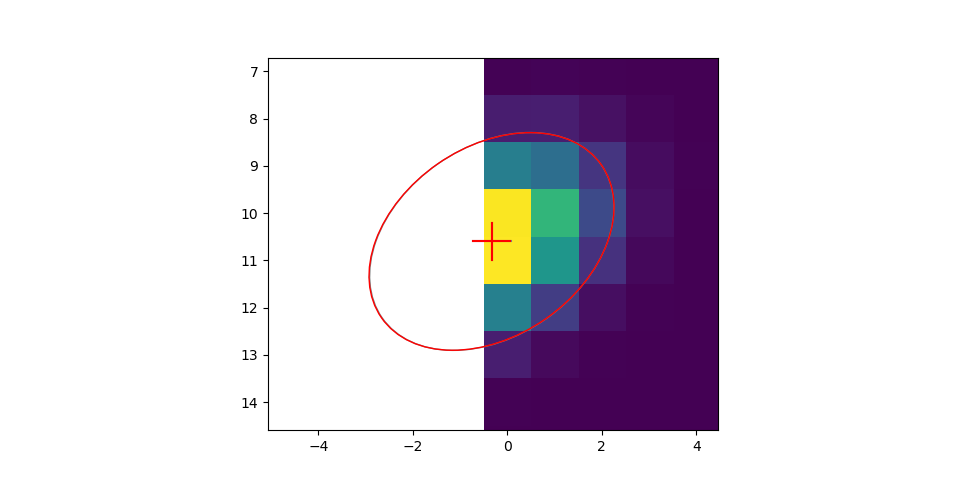

In [34]:
# plot
fig, ax = plt.subplots()
ax.imshow(data.T)

for mu, sigma in params_real:
    plot_gaussian(ax, mu, sigma, 2.0, color='grey')

for mu, sigma in params_est:
    plot_gaussian(ax, mu, sigma, 2.0, color='red')

In terms of accuracy, the result is good, as we expect, but it took us almost 50 BFGS iterations to get there, with each iteration running over the full sensor image.
Similar to the GMM method, we are able to reduce the number of iterations by trading them in for reduced accuracy.

However, we can also make another observation that will give us a performance boost:
As we are solving directly for the unknowns describing the contact area, we do not have to use the full sensor image but can get away with only a couple of points, since we only have seven unknowns.
Note that if this were a linear system of equations, we'd actually only need seven points, but since it is not linear we need more.
Furthermore we have a system with noise, so we should also use more points than the absolute minimum.

Now let's re-define the functions above to consider only a sub-part of the full sensor image:

In [35]:
def loss(c, mu, sigma_inv, data, area):
    mu = np.matrix(mu).T
    sigma_inv = np.matrix(sigma_inv)

    result = 0.0
    for x1, x2 in itertools.product(range(area[0][0], area[0][1]), range(area[1][0], area[1][1])):
        x = np.matrix([x1, x2]).T
        d = x - mu

        a = -0.5 * (d.T * sigma_inv * d).item()
        result += (c * np.exp(a) - data[x1, x2])**2
    
    return result

def d_loss_d_c(c, mu, sigma_inv, data, area):
    mu = np.matrix(mu).T
    sigma_inv = np.matrix(sigma_inv)

    result = 0.0
    for x1, x2 in itertools.product(range(area[0][0], area[0][1]), range(area[1][0], area[1][1])):
        x = np.matrix([x1, x2]).T
        d = x - mu

        a = -0.5 * (d.T * sigma_inv * d).item()
        result += (c * np.exp(a) - data[x1, x2]) * np.exp(a)
    
    return 2.0 * result

def d_loss_d_mu(c, mu, sigma_inv, data, area):
    mu = np.matrix(mu).T
    sigma_inv = np.matrix(sigma_inv)

    result = np.matrix(np.zeros(shape=(2,)))
    for x1, x2 in itertools.product(range(area[0][0], area[0][1]), range(area[1][0], area[1][1])):
        x = np.matrix([x1, x2]).T
        d = x - mu
        
        a = -0.5 * (d.T * sigma_inv * d).item()
        result += (c * np.exp(a) - data[x1, x2]) * np.exp(a) * (d.T * sigma_inv)
    
    return 2.0 * c * result

def d_loss_d_sigma(c, mu, sigma_inv, data, area):
    mu = np.matrix(mu).T
    sigma_inv = np.matrix(sigma_inv)

    result = np.zeros(shape=(2,2))
    for x1, x2 in itertools.product(range(area[0][0], area[0][1]), range(area[1][0], area[1][1])):
        x = np.matrix([x1, x2]).T
        d = x - mu
        
        a = -0.5 * (d.T * sigma_inv * d).item()
        result += (c * np.exp(a) - data[x1, x2]) * np.exp(a) * (d * d.T)
    
    return -1.0 * c * result

In [36]:
def area(center, delta, n):
    center = np.rint(center).astype(np.int)

    range_x = (max(center[0] - delta[0], 0), (min(center[0] + delta[0], n[0] - 1)))
    range_y = (max(center[1] - delta[1], 0), (min(center[1] + delta[1], n[1] - 1)))

    return (range_x, range_y)

def optimize_single(data, c_init, mu_init, sigma_init, drange=(2, 2), **kwargs):
    result = optimize.fmin_bfgs(
        f=objfn, fprime=objfprime, args=(data, area(mu_init, drange, data.shape)),
        x0=pack(c_init, mu_init, sigma_init),
        **kwargs)

    c, mu, sigma_inv = unpack(result)
    return c, mu, np.linalg.inv(sigma_inv)

c, mu_est, sigma_est = optimize_single(data, 1.0, mu_init[0], sigma_init[0], drange=(3, 2), maxiter=100, disp=True)
params_est = [(mu_est, sigma_est)]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 53
         Function evaluations: 55
         Gradient evaluations: 55


<IPython.core.display.Javascript object>


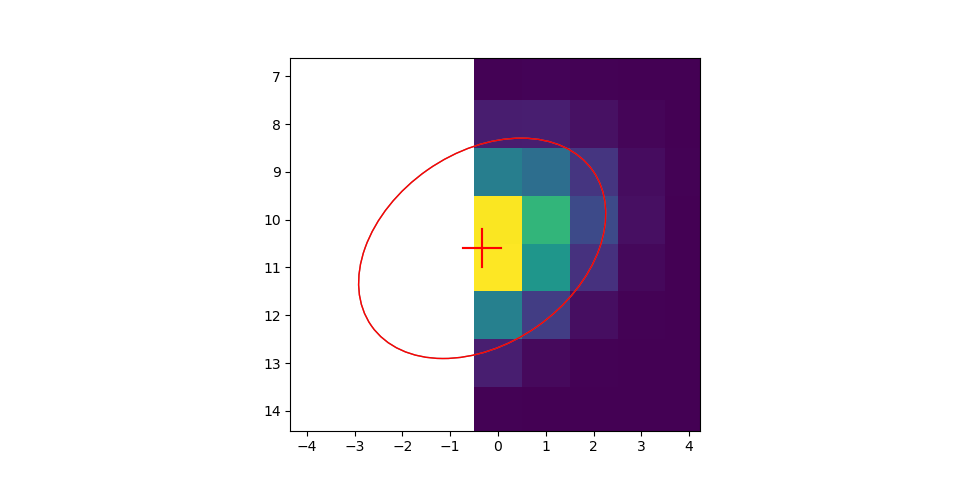

In [37]:
# plot
fig, ax = plt.subplots()
ax.imshow(data.T)

for mu, sigma in params_real:
    plot_gaussian(ax, mu, sigma, 2.0, color='grey')

for mu, sigma in params_est:
    plot_gaussian(ax, mu, sigma, 2.0, color='red')

While this does not change the number of iterations required, this significantly reduces the number of points being looked at and thus the time it takes to compute the result, all while keeping the desired accuracy.
Note that we could implement something similar for the GMM scheme, however, there we would have to ensure that the probability mass is sufficiently covered, something we do not have to worry about here.
Also, we've just introduced a second performance-accuracy trade-off:
The size (and location) of the area of interest.

### Extension to Overlapping Contact Areas

To handle overlapping contact areas, we can follow the same approach that we've used for the GMM-based method.
Let's start with the same input data we've already used above for this case:

In [38]:
# parameters for data
mu1_real = np.array([11.9, 10.6])
sigma1_real = cov(np.deg2rad(-35), 1.0, 2.0)

mu2_real = np.array([15.1, 10.6])
sigma2_real = cov(np.deg2rad(35), 1.0, 2.0)

params_real = [(mu1_real, sigma1_real), (mu2_real, sigma2_real)]

# simulate input data
data = generate_input(input_width, input_height, params_real)

# initial estimate
mu_init = get_local_maximas(data)
sigma_init = [np.identity(2), np.identity(2)]

params_init = list(zip(mu_init, sigma_init))

<IPython.core.display.Javascript object>


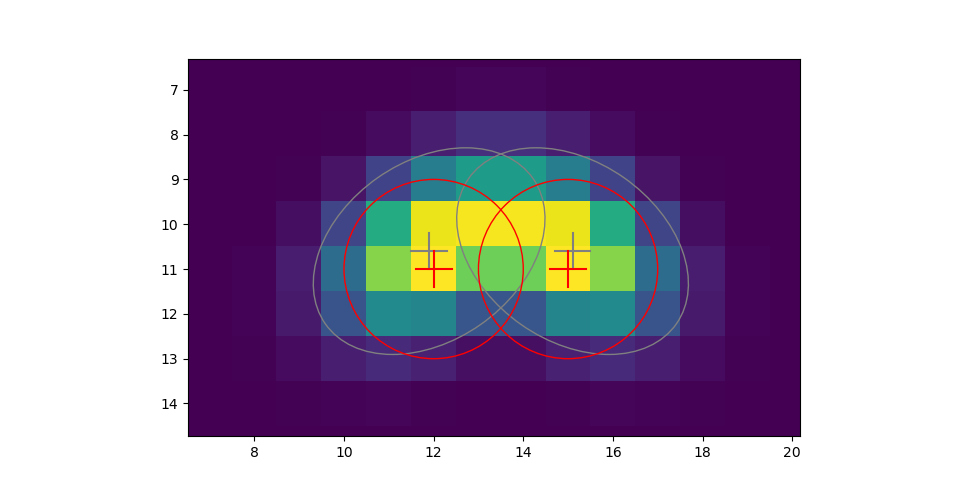

In [39]:
# plot
fig, ax = plt.subplots()
ax.imshow(data.T)

for mu, sigma in params_real:
    plot_gaussian(ax, mu, sigma, 2.0, color='grey')

for mu, sigma in params_init:
    plot_gaussian(ax, mu, sigma, 2.0, color='red')

The idea we've used for the GMM-based approach is that we estimate a contribution factor for each data point and Gaussian according to its current parameters and then weight the input for the next estimation step of this Gaussian accordingly.
We will now do exactly the same for the optimization problem, however, to easily integrate this idea into the existing solver framework we will compute a full input image for each Gaussian and interleave run some sovler iterations on those before updating this weighted input image.
This then leads to

In [40]:
def data_maps(data, params):
    p = np.zeros((len(params), data.shape[0], data.shape[1]))

    for i, (c, mu, sigma) in enumerate(params):
        for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
            p[i, x1, x2] = multivariate_normal.pdf(np.array([x1, x2]), mu, sigma)

    s = np.sum(p, axis=0)
    for i in range(p.shape[0]):
        p[i, :, :] = data * np.divide(p[i, :, :], s, where=s!=0)
    
    return p

def optimize_multi(data, params_init, n_iter, drange=(2, 2), **solver_args):
    params = params_init
    
    for i in range(n_iter):
        print(f"Iteration {i}:")
        cdata = data_maps(data, params)

        params_est = []
        for j in range(cdata.shape[0]):
            c = params[j][0]
            mu = params[j][1]
            sigma = params[j][2]
            result = optimize_single(cdata[j], c, mu, sigma, drange=drange, **solver_args)
            params_est.append(result)

        print()
        params = params_est
    
    return params

With this, we will now run 3 outer iterations with a maximum of 30 solver iterations each:

In [41]:
params_initc = [(1.0, mu, sigma) for (mu, sigma) in params_init]
params_est = optimize_multi(data, params_initc, 3, maxiter=30, disp=True)
params_est = [(mu, sigma) for (c, mu, sigma) in params_est]

Iteration 0:
         Current function value: 0.000003
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
         Current function value: 0.000254
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31

Iteration 1:
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 29
         Function evaluations: 37
         Gradient evaluations: 37
         Current function value: 0.000003
         Iterations: 30
         Function evaluations: 36
         Gradient evaluations: 36

Iteration 2:
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 34
         Gradient evaluations: 34
         Current function value: 0.000000
         Iterations: 30
         Function evaluations: 37
         Gradient evaluations: 37



<IPython.core.display.Javascript object>


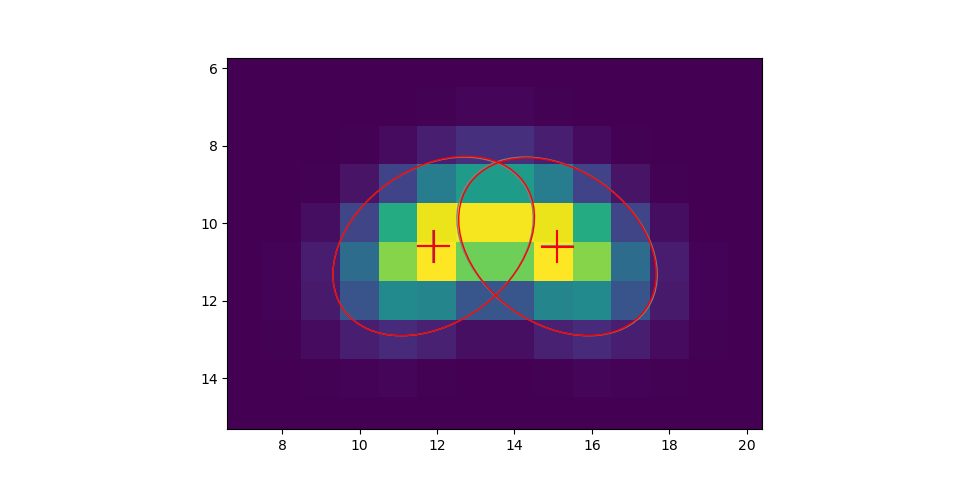

In [42]:
# plot
fig, ax = plt.subplots()
ax.imshow(data.T)

for mu, sigma in params_real:
    plot_gaussian(ax, mu, sigma, 2.0, color='grey')

for mu, sigma in params_est:
    plot_gaussian(ax, mu, sigma, 2.0, color='red')

As we can see, this gives us a near-perfect reconstruction, however, at the cost of introducing yet even more computational complexity.
We now need a total of $n_{\text{outer}} \cdot n_{\text{inner}} \cdot n_{\text{contacts}}$ (BFGS) solver iterations, in our case $3 \cdot 30 \cdot 2 = 180$, for full 10 finger touch $3 \cdot 30 \cdot 10 = 900$ (neglecting potential false-positives introduced e.g. by the palm touching the screen).
Each solver iteration has to iterate over a subset of the sensor image (once for the loss evaluation and once for the gradient evaluation), in our case $5 \times 5$, and in each outer iteration we need to perform $w \cdot h \cdot n_{\text{contacts}}$ Gaussian PDF evaluations, in our case a maximum of $72 \cdot 48 \cdot 10 = 34560$.

If we now look at the boundary situation again (or look at the test run above) we notice that we need more inner solver iterations to acheive a similar level of accuracy. So on the boundary we have a maximum (again neglecting potential false-positives which we will also have to handle at this stage) $3 \cdot 50 \cdot 10 = 1500$ iterations. 

Iteration 0:
         Current function value: 0.000000
         Iterations: 50
         Function evaluations: 52
         Gradient evaluations: 52

Iteration 1:
         Current function value: 0.000000
         Iterations: 50
         Function evaluations: 53
         Gradient evaluations: 53

Iteration 2:
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 46
         Function evaluations: 53
         Gradient evaluations: 53



<IPython.core.display.Javascript object>


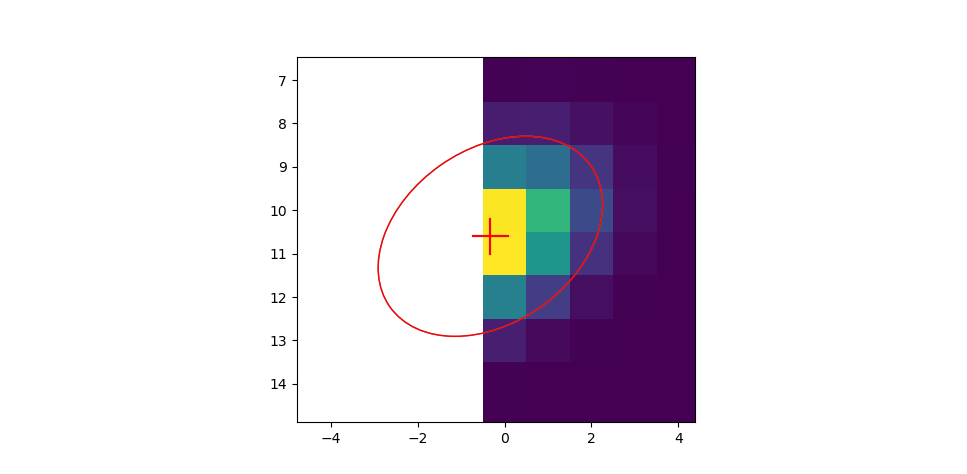

In [43]:
# parameters for data
mu_real = np.array([-0.33, 10.6])
sigma_real = cov(np.deg2rad(-35), 1.0, 2.0)

params_real = [(mu_real, sigma_real)]

# simulate input data
data = generate_input(input_width, input_height, params_real)

# initial estimate
mu_init = get_local_maximas(data)
sigma_init = [np.identity(2)]

params_init = list(zip(mu_init, sigma_init))

# solve
params_initc = [(1.0, mu, sigma) for (mu, sigma) in params_init]
params_est = optimize_multi(data, params_initc, 3, drange=(3, 2), maxiter=50, disp=True)
params_est = [(mu, sigma) for (c, mu, sigma) in params_est]

# plot
fig, ax = plt.subplots()
ax.imshow(data.T)

for mu, sigma in params_real:
    plot_gaussian(ax, mu, sigma, 2.0, color='grey')

for mu, sigma in params_est:
    plot_gaussian(ax, mu, sigma, 2.0, color='red')

Apart from our performance concerns, we now have a method that provides us with sufficiently accurate contact point descriptors, even in cases where they might overlap or be partially on the edge.

### Solving via System of Linear Equations

In an attempt to get a faster way to this solution let's look at the original problem we're trying to solve again, specifically the constraints we want to fulfill, and log-transform and expand it (we're essentially following Caruana's algorithm in 2D here):

$$
\begin{align*}
    \alpha \cdot \exp \left( -\frac{1}{2} (x_i - \mu)^\intercal \Sigma^{-1} (x_i - \mu) \right) &= y_i \\
    \log \alpha - \frac{1}{2} (x_i - \mu)^\intercal \Sigma^{-1} (x_i - \mu) &= \log y_i \\
    \log \alpha - \frac{1}{2} x_i^\intercal \Sigma^{-1} x_i + \mu^\intercal \Sigma^{-1} x
        - \frac{1}{2} \mu^\intercal \Sigma^{-1} \mu
        &= \log y_i
\end{align*}
$$

Continuing from this, we substitute

$$
\begin{align*}
    A &= - \frac{1}{2} \Sigma^{-1} \\
    b &= \Sigma^{-1} \mu \\
    c &= \log \alpha - \frac{1}{2} \mu^\intercal \Sigma^{-1} \mu
\end{align*}
$$

to obtain the equation

$$
    x_i^\intercal A x_i + b^\intercal x_i + c = \log y_i.
$$

With that, we have a form that is linear in $A$, $b$, and $c$, simplifying the fitting process from a nonlinear problem significantly.
When looking at this equation from the perspective of $x$, we essentially fit a paraboloid to the log-transformed data.
If we have the parameters of this paraboloid, we can easily compute the parameters from the Gaussian.

We can now solve the linearized problem using standard least-squares penalization on the error (n.b.: Guo's algorithm uses an iterative weighted least-squares approach which seems to perform better with regards to noisy input data \[Gou, IEEE Signal Processing Magazine, 2011\]), by solving the optimization problem

$$
\begin{align*}
    \theta^{*} &= \operatorname*{arg\,min}_{A, b, c} \mathcal{L}(A, b, c), \\
    \mathcal{L}(A, b, c) &= \sum_{(x_i, y_i) \in \mathcal{S}}
        \Big( \log y_i - \left( x_i^\intercal A x_i + b^\intercal x_i + c \right) \Big)^2,
\end{align*}
$$

with partial derivatives

$$
\begin{align*}
    \frac{\partial}{\partial A} \mathcal{L}(A, b, c)
        &= -2 \cdot \sum_{(x_i, y_i) \in \mathcal{S}}
            \Big( \log y_i - x_i^\intercal A x_i - b^\intercal x_i - c \Big)
            \cdot x_i x_i^\intercal, \\
    \frac{\partial}{\partial b} \mathcal{L}(A, b, c)
        &= -2 \cdot \sum_{(x_i, y_i) \in \mathcal{S}}
            \Big( \log y_i - x_i^\intercal A x_i - b^\intercal x_i - c \Big)
            \cdot x_i^\intercal, \\
    \frac{\partial}{\partial c} \mathcal{L}(A, b, c)
        &= -2 \cdot \sum_{(x_i, y_i) \in \mathcal{S}}
            \Big( \log y_i - x_i^\intercal A x_i - b^\intercal x_i - c \Big).
\end{align*}
$$

Following the standard analytical scheme for solving these kinds of problems by setting these gradients to zero yields a linear system of equations with six unknowns (note that $a_{1,2} = a_{2,1}$).

$$
\begin{align*}
    \sum_{(x_i, y_i) \in \mathcal{S}} x_i^\intercal A x_i \cdot x_i x_i^\intercal
            + b^\intercal x_i \cdot x_i x_i^\intercal
            + c \cdot x_i x_i^\intercal
        &= \sum_{(x_i, y_i) \in \mathcal{S}} \log y_i \cdot x_i x_i^\intercal \\
    \sum_{(x_i, y_i) \in \mathcal{S}} x_i^\intercal A x_i \cdot x_i^\intercal
            + b^\intercal x_i \cdot x_i^\intercal
            + c \cdot x_i^\intercal
        &= \sum_{(x_i, y_i) \in \mathcal{S}} \log y_i \cdot x_i^\intercal \\
    \sum_{(x_i, y_i) \in \mathcal{S}} x_i^\intercal A x_i + b^\intercal x_i + c
        &= \sum_{(x_i, y_i) \in \mathcal{S}} \log y_i
\end{align*}
$$

We can now expand this and bring it into matrix form, leading to

$$
\begin{bmatrix}
    \sum_i x_{1,i}^4 & 2 \sum_i x_{1,i}^3 x_{2,i} & \sum_i x_{1,i}^2 x_{2,i}^2
        & \sum_i x_{1,i}^3 & \sum_i x_{1,i}^2 x_{2,i}
        & \sum_i x_{1,i}^2 \\
    \sum_i x_{1,i}^3 x_{2,i} & 2 \sum_i x_{1,i}^2 x_{2,i}^2 & \sum_i x_{1,i} x_{2,i}^3
        & \sum_i x_{1,i}^2 x_{2,i} & \sum_i x_{1,i} x_{2,i}^2
        & \sum_i x_{1,i} x_{2,i} \\
    \sum_i x_{1,i}^2 x_{2,i}^2 & 2 \sum_i x_{1,i} x_{2,i}^3 & \sum_i x_{2,i}^4
        & \sum_i x_{1,i} x_{2,i}^2 & \sum_i x_{2,i}^3
        & \sum_i x_{2,i}^2 \\
    \sum_i x_{1,i}^3 & 2 \sum_i x_{1,i}^2 x_{2,i} & \sum_i x_{1,i} x_{2,i}^2
        & \sum_i x_{1,i}^2 & \sum_i x_{1,i} x_{2,i}
        & \sum_i x_{1,i} \\
    \sum_i x_{1,i}^2 x_{2,i} & 2 \sum_i x_{1,i} x_{2,i}^2 & \sum_i x_{2,i}^3
        & \sum_i x_{1,i} x_{2,i} & \sum_i x_{2,i}^2
        & \sum_i x_{2,i} \\
    \sum_i x_{1,i}^2 & 2 \sum_i x_{1,i} x_{2,i} & \sum_i x_{2,i}^2
        & \sum_i x_{1,i} & \sum_i x_{2,i}
        & |\mathcal{S}|
\end{bmatrix}
\cdot
\begin{bmatrix}
    a_{1,1} \\
    a_{1,2} \\
    a_{2,2} \\
    b_1     \\
    b_2     \\
    c       \\
\end{bmatrix}
=
\begin{bmatrix}
    \sum_i \log y_i \cdot x_{1,i}^2   \\
    \sum_i \log y_i \cdot x_{1,i} x_2 \\
    \sum_i \log y_i \cdot x_{2,i}^2   \\
    \sum_i \log y_i \cdot x_{1,i}     \\
    \sum_i \log y_i \cdot x_{2,i}     \\
    \sum_i \log y_i                   \\
\end{bmatrix}
$$

Given that we use enough data points, this system is solvable and has a unique solution, which we can obtain via a standard SLE solver.
As stated above, the solution of this system represents the parameters for the paraboloid fitted to the log-transformed data, which can be converted to a Gaussian on the non-transformed data.

As a last step, note that while it looks a bit scary at first, this system can actually be written down and implemented a lot simpler by defining a fundamental vector $\phi(x_i)$ as

$$
\begin{align*}
    \phi_i
    &:= \phi(x_i) \\
    &:= \begin{bmatrix}
            x_{1,i}^2 & 2 x_{1,i} x_{2,i} & x_{2,i}^2 & x_{1,i} & x_{2,i} & 1
        \end{bmatrix}^\intercal.
\end{align*}
$$

Using this, we can write the system matrix as a sum of outer products of this vector and the right hand side via a simple weighted sum, yielding in full

$$
\left( \sum_{(x_i, y_i) \in \mathcal{S}} \phi_i \phi_i^\intercal \right) \chi
    = \sum_{(x_i, y_i) \in \mathcal{S}} \phi_i \log y_i,
$$

where $\chi$ is the vector containing our unknowns (i.e. $A$, $b$, and $c$).

With this simplified form, we can then start implementing our new method, again first for a single contact point.
For this, we define two helper functions, one that assembles the system matrix and right-hand side of the SLE, and the other one that transforms the SLE parameters back to the Gaussian parameters.

In [44]:
def assemble_system(data, center, drange):
    range_xy = area(center, drange, data.shape)

    system = np.zeros(shape=(6,6))
    rhs = np.zeros(shape=(6,))
    
    for x1, x2 in itertools.product(range(range_xy[0][0], range_xy[0][1]), range(range_xy[1][0], range_xy[1][1])):
        if data[x1, x2] < 1e-20:
            continue

        base = np.array([x1**2, 2 * x1 * x2, x2**2, x1, x2, 1.0])
        system += np.outer(base, base)
        rhs += np.log(data[x1, x2]) * base

    return system, rhs

def gaussian_from_sle(a, b, c):
    sigma_inv = -2.0 * a
    sigma = np.matrix(np.linalg.inv(sigma_inv))
    
    mu = sigma * np.matrix(b).T
    
    alpha = np.exp(c + 0.5 * (mu.T * sigma_inv * mu).item())
    
    return alpha, np.array(mu).flatten(), sigma

Using those, we can implement our fitting method for a single point via

In [45]:
def fit_single(data, mu_init, drange=(2, 2)):
    # assemble and solve system
    system, rhs = assemble_system(data, mu_init, drange=drange)
    chi = np.linalg.solve(system, rhs)

    # extract parameters
    a = np.array([[chi[0], chi[1]], [chi[1], chi[2]]])
    b = chi[3:5]
    c = chi[5]

    # convert to Gaussian and return
    return gaussian_from_sle(a, b, c)

and finally test it:

<IPython.core.display.Javascript object>


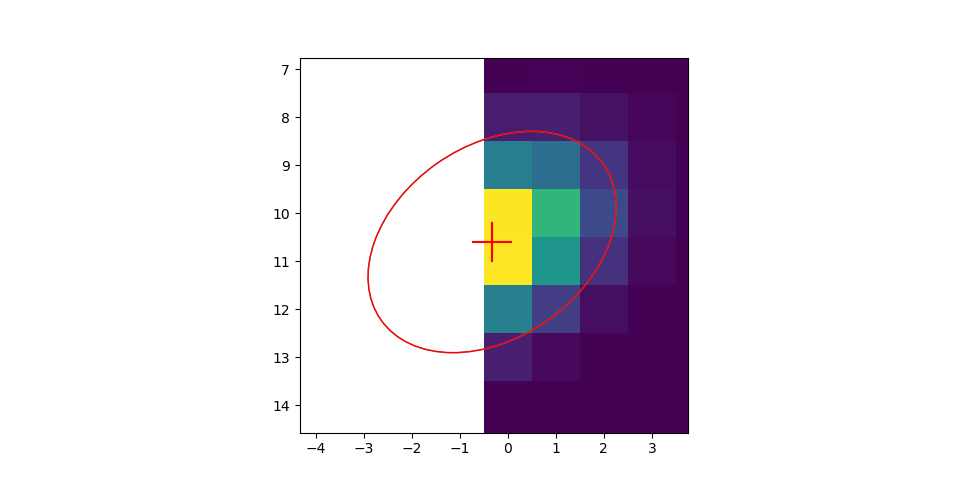

In [46]:
# solve
alpha_est, mu_est, sigma_est = fit_single(data, mu_init[0], drange=(3, 2))
params_est = [(mu_est, sigma_est)]

# plot
fig, ax = plt.subplots()
ax.imshow(data.T)

for mu, sigma in params_real:
    plot_gaussian(ax, mu, sigma, 2.0, color='grey')

for mu, sigma in params_est:
    plot_gaussian(ax, mu, sigma, 2.0, color='red')

As expected, the results look good for our boundary scenario, with a single contact point.

Extension to overlapping contact areas is done following the scheme above.
We first define our input data again.

In [47]:
# parameters for data
mu1_real = np.array([11.9, 10.6])
sigma1_real = cov(np.deg2rad(-35), 1.0, 2.0)

mu2_real = np.array([15.1, 10.6])
sigma2_real = cov(np.deg2rad(35), 1.0, 2.0)

params_real = [(mu1_real, sigma1_real), (mu2_real, sigma2_real)]

# simulate input data
data = generate_input(input_width, input_height, params_real)

# initial estimate
mu_init = get_local_maximas(data)
sigma_init = [np.identity(2), np.identity(2)]

params_init = list(zip(mu_init, sigma_init))

Next, we extend our single-contact approach iteratively by using the same weighted input data as before.

In [48]:
def fit_multi(data, params_init, n_iter, drange=(2, 2)):
    params = params_init
    
    for i in range(n_iter):
        print(f"Iteration: {i}")
        cdata = data_maps(data, params)

        params_est = []
        for j in range(cdata.shape[0]):
            mu = params[j][1]
            result = fit_single(cdata[j], mu, drange=drange)
            params_est.append(result)

        params = params_est
    
    return params

Finally, we can evaluate it:

Iteration: 0
Iteration: 1
Iteration: 2


<IPython.core.display.Javascript object>


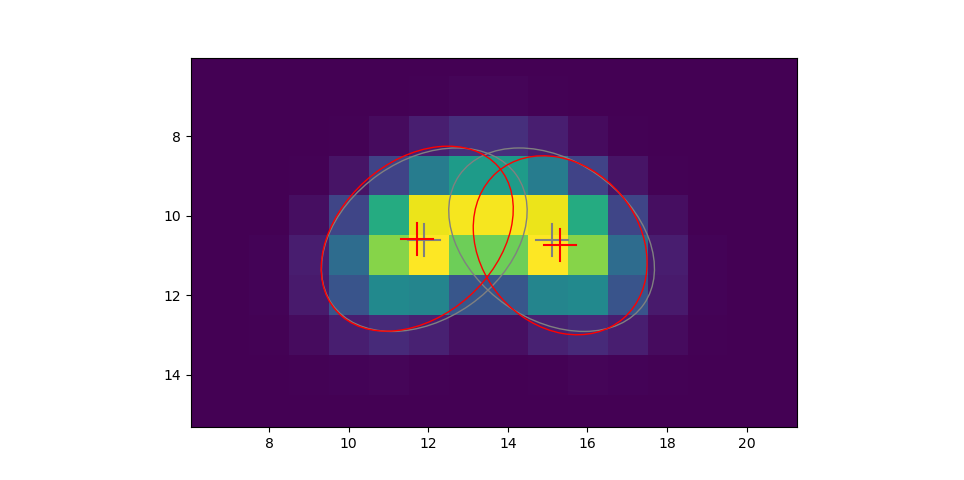

In [49]:
# solve
params_initc = [(1.0, mu, sigma) for (mu, sigma) in params_init]
params_est = fit_multi(data, params_initc, 3, drange=(4, 4))
params_est = [(mu, sigma) for (c, mu, sigma) in params_est]

# plot
fig, ax = plt.subplots()
ax.imshow(data.T)

for mu, sigma in params_real:
    plot_gaussian(ax, mu, sigma, 2.0, color='grey')

for mu, sigma in params_est:
    plot_gaussian(ax, mu, sigma, 2.0, color='red')

Unfortunately, the results don't look great.
Due to the application of the logarithm, we get a different weighting for the error.
This means that the parts of the Gaussian that are actually small, i.e. on the tail, are weighted more with our new approach compared to our initial optimization problem.
A fix for this is the use of a weighted least squares penalizer, as proposed by Guo with the intent to combat the impact of noise.
Note that our scenario here is actually quite similar to noise in the input data, as the respectively other Gaussian basically represents noisy data for the one we're currently interested in.

Application of the weighting scheme is fairly easy by just multiplying $y_i^2$ to the respective summand, leading to the SLE

$$
\left( \sum_{(x_i, y_i) \in \mathcal{S}} y_i^2 \phi_i \phi_i^\intercal \right) \chi
    = \sum_{(x_i, y_i) \in \mathcal{S}} \phi_i y_i^2 \log y_i,
$$

with $\phi_i$ as above.
Thus, we only have to change the system matrix and right-hand side via

In [50]:
def assemble_system(data, center, drange):
    range_xy = area(center, drange, data.shape)

    system = np.zeros(shape=(6,6))
    rhs = np.zeros(shape=(6,))
    
    for x1, x2 in itertools.product(range(range_xy[0][0], range_xy[0][1]), range(range_xy[1][0], range_xy[1][1])):
        if data[x1, x2] < 1e-20:
            continue

        base = np.array([x1**2, 2 * x1 * x2, x2**2, x1, x2, 1.0])
        system += np.outer(base, base) * data[x1, x2]**2
        rhs += np.log(data[x1, x2]) * base * data[x1, x2]**2

    return system, rhs

and then can test it again via

Iteration: 0
Iteration: 1
Iteration: 2


<IPython.core.display.Javascript object>


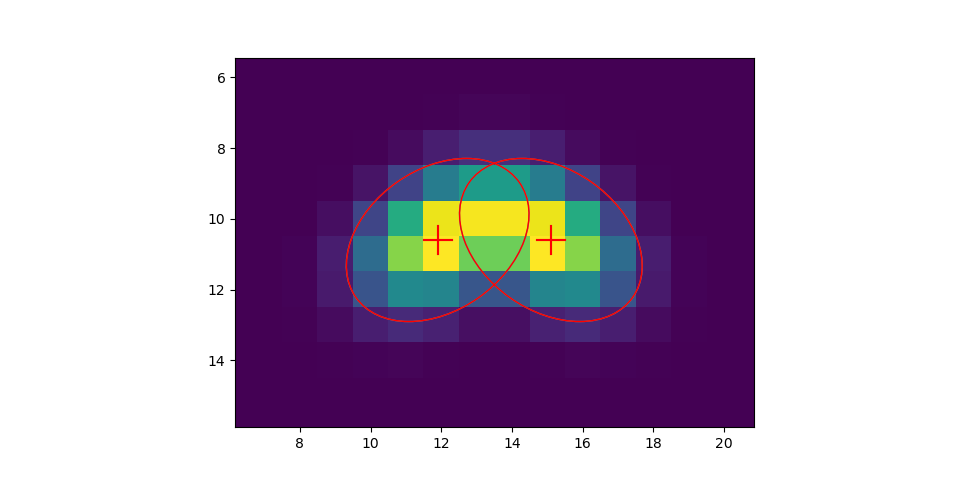

In [51]:
# solve
params_initc = [(1.0, mu, sigma) for (mu, sigma) in params_init]
params_est = fit_multi(data, params_initc, 3, drange=(4, 4))
params_est = [(mu, sigma) for (c, mu, sigma) in params_est]

# plot
fig, ax = plt.subplots()
ax.imshow(data.T)

for mu, sigma in params_real:
    plot_gaussian(ax, mu, sigma, 2.0, color='grey')

for mu, sigma in params_est:
    plot_gaussian(ax, mu, sigma, 2.0, color='red')

With that, the result looks good again. In terms of performance there is still one thing left to do (apart from micro-optimizing): We should consider computing the corrected data (for which we need to evaluate Gaussians) only for the respective areas of interest.

As an additional note: Our iterative algorithm is actually quite similar to Guo's iterative algorithm, with the exception that in his iterative algorithm, Guo uses the estimated Gaussian to compute the weights instead of using the (corrected) input data, which is more stable with regards to noise.
We may need to change this in our algorithm when we get to the subject of dealing with noisy data.

TODO:
- Try decomposing covariance into eigenvectors and eigenvalues for optimization problem?
- Performance optimizations.
- ...

## Other Ideas

### Directly Solving for Eigenvalues and Eigenvectors 

Since we're now solving an optimization problem, can we directly solve for the eigenvalues and eigenvectors?
Real symmetric matrices $A$ (such as our covariance $\Sigma$), can be (de-)composed as $A = Q \Lambda Q^\intercal$, where $Q$ contains the orthonormal eigenvectors and $\Lambda$ is a diagonal matrix containing the eigenvalues.
For our 2D covariance matrix $\Sigma$ with eigenvectors $e_1, e_2$ and eigenvalues $\lambda_1, \lambda_2$, this means

$$
\Sigma = \lambda_1 e_1 e_1^\intercal + \lambda_2 e_2 e_2^\intercal.
$$

Note that $e_1 \perp e_2$ and $\|e_1\| = \|e_2\| = 1$.
Due to the orthogonality in 2D, we can now express the second eigenvector ($e_2$) in terms of the first one ($e_1$) via the 90° rotation matrix $R$:

$$
e_2 = R e_1
$$

where

$$
R = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}.
$$

Using this, we can rewrite the covariance as

$$
\begin{align*}
    \Sigma
    &= \lambda_1 e_1 e_1^\intercal + \lambda_2 e_2 e_2^\intercal, \\
    &= \lambda_1 e_1 e_1^\intercal + \lambda_2 (R e_1) (R e_1)^\intercal, \\
    &= \lambda_1 e_1 e_1^\intercal + \lambda_2 R e_1 e_1^\intercal R^\intercal,
\end{align*}
$$

only depending on $e_1$.
Now we're actually estimating the inverse, so how does that help us?
For this, we can make use of a neat trick:
The eigenvector of a matrix $A$ is also the eigenvector of its inverse $A^{-1}$, with the eigenvalue of one divided by the original eigenvalue.
This can be proven easily via

$$
\begin{align*}
    Ax &= \alpha x, \\
    x &= \alpha A^{-1} x, \\
    \frac{1}{\alpha} x &= A^{-1} x,
\end{align*}
$$

where $x$ is an eigenvector and $\alpha$ the corresponding eigenvalue of $A$.
Applying this knowledge to the inverse covariance matrix yields

$$
\begin{align*}
    \Sigma^{-1}
    &= \frac{1}{\lambda_1} e_1 e_1^\intercal + \frac{1}{\lambda_2} e_2 e_2^\intercal \\
    &= \frac{1}{\lambda_1} e_1 e_1^\intercal + \frac{1}{\lambda_2} R e_1 e_1^\intercal R^\intercal. \\
\end{align*}
$$

If we try to plug this into our problem above and optimize for $e_1$, $\lambda_1$, and $\lambda_2$ instead of $\Sigma^{-1}$, we will, however, run into a bit of a problem:
We have constrained the eigenvector $e_1$ to be normalized.
As we have not expressed this constraint to the optimizer in any way, it won't enforce it.
Furthermore, since it doesn't enforce the constraint, the solutions for $e_1$ and $\lambda_1$ will become (even more) ambiguous.
Luckily, the solution is fairly simple:
Search for a scaled vector which integrates the eigenvalue.
For this we define

$$
e = \frac{1}{\sqrt{\lambda_1}} e_1,
$$

which, when applied to our decomposition of $\Sigma^{-1}$ gives us

$$
\begin{align*}
    \Sigma^{-1}
    &= \frac{1}{\lambda_1} e_1 e_1^\intercal + \frac{1}{\lambda_2} R e_1 e_1^\intercal R^\intercal \\
    &= ee^\intercal + \frac{\lambda_1}{\lambda_2} R e e^\intercal R^\intercal \\
    &= ee^\intercal + \lambda R e e^\intercal R^\intercal
\end{align*}
$$

With this formulation, we only search for 3 unknowns: Two via $e \in \mathbb{R}^2$ and the scalar $\lambda$ (as opposed to the four that $\Sigma^{-1} \in \mathbb{R}^{2 \times 2}$ provided us with).
Note that this still creates a problem with a non-unique solution:
Just think how you could rotate the vector $e$ by 90° and scale accordingly, which leaves the option for four solutions.
However, each solution is equally well suited, so as long as we converge to one, we will be fine (but may need some sort of normalization at the end).

With this, we can then retrieve the actual eigenvalues from $e$ and $\lambda$ via

$$
\begin{align*}
    \lambda_1 &= \frac{1}{e^\intercal e}, \\
    \lambda_2 &= \frac{\lambda_1}{\lambda}.
\end{align*}
$$

In case we need the actual covariance matrix $\Sigma$, we can continue the decomposition started above and just plug in the equations for $e_1$, $\lambda_1$, and $\lambda_2$:



$$
\begin{align*}
    \Sigma
    &= \lambda_1 e_1 e_1^\intercal + \lambda_2 R e_1 e_1^\intercal R^\intercal \\
    &= \lambda_1^2 ee^\intercal + \lambda_2 \lambda_1 R ee^\intercal R^\intercal \\
    &= \frac{ee^\intercal}{\left(e^\intercal e\right)^2}
        + \frac{\lambda_1^2}{\lambda} R ee^\intercal R^\intercal \\
    &= \frac{ee^\intercal}{\left(e^\intercal e\right)^2}
        + \frac{1}{\lambda} R \frac{ee^\intercal}{\left(e^\intercal e\right)^2} R^\intercal \\
\end{align*}
$$

And for all that, we don't even need a square root (let alone computing matrix inverse and eigenvalue decompositions).
However, we will need to derive some new gradients to replace the one for $\Sigma^{-1}$.